In [ ]:
𝐈𝐍𝐓𝐑𝐔𝐒𝐈𝐎𝐍 𝐃𝐄𝐓𝐄𝐂𝐓𝐈𝐎𝐍 𝐒𝐘𝐒𝐓𝐄𝐌 𝐔𝐒𝐈𝐍𝐆 𝐌𝐔𝐋𝐓𝐈-𝐋𝐄𝐕𝐄𝐋 𝐑𝐀𝐍𝐃𝐎𝐌 𝐅𝐎𝐑𝐄𝐒𝐓 𝐏𝐎𝐖𝐄𝐑𝐄𝐃 𝐁𝐘 𝐅𝐔𝐙𝐙𝐘 𝐈𝐍𝐅𝐄𝐑𝐄𝐍𝐂𝐄 𝐒𝐘𝐒𝐓𝐄𝐌

In [3]:
#Install required libraries
!pip install scikit-fuzzy


[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skfuzzy import control as ctrl
import skfuzzy as fuzz
import random

In [5]:
# Try to import DEAP, install if not available
try:
    from deap import base, creator, tools, algorithms
except ImportError:
    import sys
    !{sys.executable} -m pip install deap
    from deap import base, creator, tools, algorithms

import random

In [8]:
# ---------------------------
# Load and preprocess the NSL-KDD dataset
# ---------------------------

In [6]:
# Load NSL-KDD Dataset
df = pd.read_csv("NSL-KDD.csv")  # Ensure you have the dataset

# Encode categorical features
categorical_columns = ['protocol_type', 'service', 'flag', 'labels']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split features and labels
X = df.drop(columns=['labels'])
y = df['labels']

# Normalize feature values for better training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# ---------------------------
# Feature Selection Phase
# ---------------------------

In [7]:
# Step 1: Correlation-Based Feature Selection
# Select top 20 features based on their correlation with others

correlation_matrix = pd.DataFrame(X_scaled).corr().abs()
selected_features = correlation_matrix.mean().nlargest(20).index  # Select top 20 correlated features
X_selected = X_scaled[:, selected_features]

# Step 2: Genetic Algorithm (GA) for Optimized Feature Selection
# Define fitness function to maximize Random Forest accuracy
def fitness_function(individual):
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected_indices:
        return 0.,  # No features selected => zero fitness
    X_train_fs, X_test_fs, y_train, y_test = train_test_split(X_scaled[:, selected_indices], y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_fs, y_train)
    y_pred = clf.predict(X_test_fs)
    return accuracy_score(y_test, y_pred),

# Genetic Algorithm Initialization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X_scaled[0]))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run Genetic Algorithm
population = toolbox.population(n=10) # Small population for faster execution
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=True)

# Select the best individual (best feature subset)
best_individual = tools.selBest(population, k=1)[0]
selected_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
X_final = X_scaled[:, selected_indices]


gen	nevals
0  	10    
1  	8     
2  	3     
3  	6     
4  	7     
5  	9     


In [15]:
# ---------------------------
# Split Dataset for Training and Testing
# ---------------------------

In [8]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


In [17]:
# ---------------------------
# Multi-Level Random Forest Classification
# ---------------------------

In [9]:
# Level-1 Random Forest (Detection)
rf_level1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_level1.fit(X_train, y_train)
y_pred_level1 = rf_level1.predict(X_train)

# Level-2 Random Forest (Refinement)
rf_level2 = RandomForestClassifier(n_estimators=50, random_state=42)
rf_level2.fit(X_train, y_pred_level1)
y_pred_final = rf_level2.predict(X_test)


In [19]:
# ---------------------------
# Reverse Label Encoding for better readability
# ---------------------------

In [10]:
# Map back encoded labels to their original names
y_test_labels = label_encoders['labels'].inverse_transform(y_test)
y_pred_labels = label_encoders['labels'].inverse_transform(y_pred_final)

In [21]:
# ---------------------------
# Fuzzy Inference System (FIS) for Severity Assessment
# ---------------------------

In [11]:
# Define severity scale and membership functions
severity = np.arange(0, 101, 1)
low = fuzz.trimf(severity, [0, 0, 50])
medium = fuzz.trimf(severity, [30, 50, 70])
high = fuzz.trimf(severity, [60, 100, 100])


# Define severity assessment function
def assess_severity(prob):
    if prob < 0.5:
        return "Low"
    elif 0.5 <= prob < 0.8:
        return "Medium"
    else:
        return "High"

# Apply FIS to refine classification
rf_probs = rf_level2.predict_proba(X_test)[:, 1]
severity_assessments = [assess_severity(prob) for prob in rf_probs]
print("Severity Assessments Example:", severity_assessments[:10])

Severity Assessments Example: ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low']


In [12]:
# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print(classification_report(y_test_labels, y_pred_labels))

Accuracy: 0.9860279441117764
                 precision    recall  f1-score   support

        apache2       1.00      0.95      0.98        42
           back       1.00      1.00      1.00        33
buffer_overflow       0.50      0.17      0.25         6
   guess_passwd       1.00      0.98      0.99        90
     httptunnel       0.75      1.00      0.86         6
           imap       0.00      0.00      0.00         1
        ipsweep       0.99      0.94      0.96        82
           land       0.00      0.00      0.00         2
     loadmodule       0.00      0.00      0.00         1
       mailbomb       1.00      1.00      1.00        20
          mscan       1.00      0.98      0.99        56
       multihop       0.00      0.00      0.00         1
          named       0.00      0.00      0.00         1
        neptune       1.00      1.00      1.00      1374
           nmap       0.95      1.00      0.97        37
         normal       0.98      1.00      0.99      2239
 

C:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

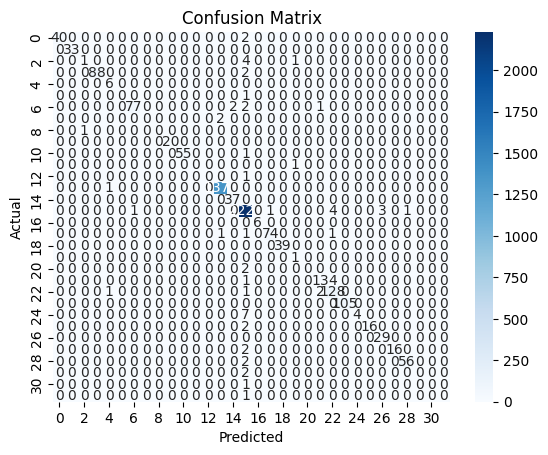

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
import pickle

In [15]:
pickle.dump(label_encoders['labels'], open('label_encoder.sav', 'wb'))

In [16]:
selected_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
with open('selected_indices.sav', 'wb') as f:
    pickle.dump(selected_indices, f)

In [24]:
#pickle.dump(selected_features, open('selected_features.sav', 'wb'))

In [17]:
filename = 'intrusion_model.sav'
# Assign the trained model to the variable 'model'
# Assuming 'rf_level2' is the final trained model you want to save:
model = rf_level2
pickle.dump(model, open(filename, 'wb'))

In [18]:
# loading the saved model
loaded_model = pickle.load(open('intrusion_model.sav', 'rb'))